In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import seaborn as sns
import ujson
import sys
import time
import itertools
import pickle

from tqdm.auto import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt

In [13]:


model_to_color = {
    "CELL_LINE": "#f58231",
    "CELL_TYPE": "#3cb44b",
    "GENEPROD": "#000075",
    "DISEASE": "#ffe119",
    "TISSUE": "#4363d8",
    "SUBCELLULAR": "#42d4f4",
    "ORGANISM": "#800000",
    "SMALL_MOLECULE": "#e6194B",
    "EXP_ASSAY": "#911eb4",
}

In [16]:
def flatten_preds(candidate_list):
    seen = set([])
    flattened = []
    for sublist in candidate_list:
        for x in sublist:
            if x not in seen:
                flattened.append(x)
                seen.add(x)
    return flattened

def analyze_one_result(truth, candidates, k=1):
    
    for x in candidates[:k]:
        if x in truth:
            return True

    return False
    

def analyze_results(all_preds, ks=range(1, 11)):
    output_accumulator = {k:[] for k in ks}
    for result_dict in all_preds:
        candidates = flatten_preds(result_dict['candidates'])
        truth = result_dict['db_ids']
        for k in ks:
            output_accumulator[k].append(analyze_one_result(truth=truth, candidates=candidates, k=k))

    output = {key: np.mean(val) for key, val in output_accumulator.items()}

    return output

def plot_recall_at_k(recall_dict, max_k=10, legend_key=None, ax=None, color=None, alpha=1):
    if ax is not None:
        ax.plot(recall_dict.keys(), recall_dict.values(), marker='o', label=legend_key, color=color, alpha=alpha)
    else:
        plt.plot(recall_dict.keys(), recall_dict.values(), marker='o', label=legend_key, color=color, alpha=alpha)

In [19]:
data_types = ['CELL_LINE', 'CELL_TYPE', 'DISEASE', 'EXP_ASSAY', 'SUBCELLULAR', 'TISSUE', 'SMALL_MOLECULE']

all_results = dict()
all_preds = dict()
for t in data_types:
    preds = ujson.load(open(f'/home/dkartchner3/research/entity_linking/biomedical-entity-linking/sapbert/output/{t}/sourcedata_nlp/0.json'))
    if t in ['CELL_LINE']:
        for p in preds:
            p['db_ids'] = [x.split(':')[-1] for x in p['db_ids']]
    all_preds[t] = preds
    all_results[t] = analyze_results(preds)


df = pd.DataFrame(all_results)
df.T.round(4)

,1,2,3,4,5,6,7,8,9,10
CELL_LINE,0.9194,0.9509,0.9515,0.9515,0.9749,0.9755,0.9755,0.9755,0.9755,0.9755
CELL_TYPE,0.6761,0.7343,0.7675,0.7953,0.8021,0.8044,0.8071,0.8157,0.8176,0.8344
DISEASE,0.5198,0.5936,0.6106,0.6408,0.6446,0.6446,0.6446,0.6484,0.6484,0.6484
EXP_ASSAY,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
SUBCELLULAR,0.7096,0.7679,0.7973,0.8107,0.8274,0.8367,0.8397,0.8453,0.8520,0.8524
TISSUE,0.0131,0.0131,0.0131,0.0131,0.0131,0.0131,0.0131,0.0131,0.0131,0.0131
SMALL_MOLECULE,0.4807,0.5915,0.6233,0.6486,0.6587,0.6697,0.6707,0.6712,0.6727,0.6727


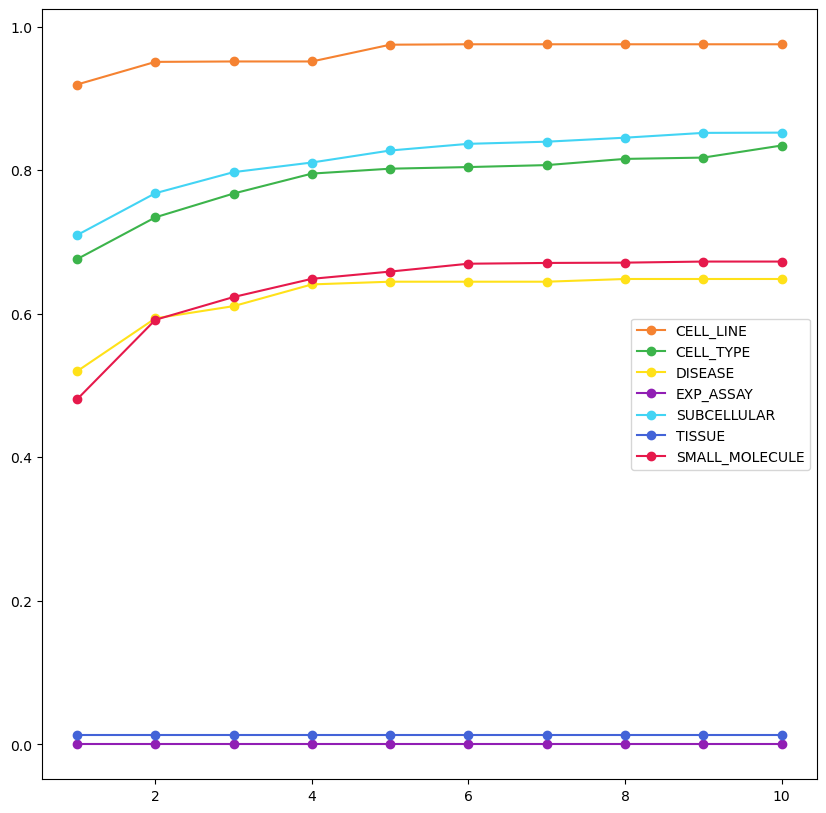

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for key, result_dict in all_results.items():
    plot_recall_at_k(result_dict, legend_key=key, color=model_to_color[key])
plt.legend()
plt.show()

In [8]:
# all_preds['EXP_ASSAY']

[{'document_id': '10.1002/embj.201385902',
  'offsets': [[2493, 2506]],
  'text': 'immunostained',
  'type': ['EXP_ASSAY'],
  'db_ids': ['BAO:BAO_0002426'],
  'split': 'test',
  'mention_id': '10.1002/embj.201385902.32',
  'candidates': [['OBI:0001986'],
   ['OBI:0002174'],
   ['OBI:0302887'],
   ['OBI:0002773'],
   ['OBI:0001686'],
   ['OBI:0002111'],
   ['OBI:0400169'],
   ['OBI:0000661'],
   ['OBI:0000916'],
   ['OBI:0000690']],
  'candidates_metadata': [{'text': 'immunohistochemistry',
    'db_id': 'OBI:0001986'},
   {'text': 'immunocytochemistry', 'db_id': 'OBI:0002174'},
   {'text': 'staining', 'db_id': 'OBI:0302887'},
   {'text': 'immunoassay', 'db_id': 'OBI:0002773'},
   {'text': 'ish', 'db_id': 'OBI:0001686'},
   {'text': 'eclip', 'db_id': 'OBI:0002111'},
   {'text': 'microscope', 'db_id': 'OBI:0400169'},
   {'text': 'elisa', 'db_id': 'OBI:0000661'},
   {'text': 'facs', 'db_id': 'OBI:0000916'},
   {'text': 'immunoprecipitation', 'db_id': 'OBI:0000690'}]},
 {'document_id': '10.

In [12]:
print(df.T.round(4).to_csv())

,1,5,10
CELL_LINE,0.0,0.0,0.0
CELL_TYPE,0.6761,0.8021,0.8344
DISEASE,0.5198,0.6446,0.6484
EXP_ASSAY,0.0,0.0,0.0
SUBCELLULAR,0.7096,0.8274,0.8524
TISSUE,0.0131,0.0131,0.0131
SMALL_MOLECULE,0.4807,0.6587,0.6727



In [ ]:
def plot_recall_at_k(recall_dict, max_k=10, legend_key=None, ax=None, color=None, alpha=1):
    if ax is not None:
        ax.plot(recall_dict.keys(), recall_dict.values(), marker='o', label=legend_key, color=color, alpha=alpha)
    else:
        plt.plot(recall_dict.keys(), recall_dict.values(), marker='o', label=legend_key, color=color, alpha=alpha)